# Example code of Segment Anything Model (SAM)

Colab 환경에서 SAM 모델을 사용해 이미지에 클릭한 위치의 객체를 segmentation 하는 예제입니다.

## 패키지 및 예제 데이터 다운로드
예제를 실행시키기 위해 python package들을 설치합니다. 예제로 사용할 이미지들도 다운로드 받습니다. Colab에서 실행하지 않는 경우 이 셀은 실행하지 않습니다.

In [3]:
!wget https://raw.githubusercontent.com/mrsyee/dl_apps/main/segmentation/requirements-colab.txt
!pip install -r requirements-colab.txt

# 예제 이미지 다운로드
!mkdir examples
!cd examples && wget https://raw.githubusercontent.com/mrsyee/dl_apps/main/segmentation/examples/dog.jpg
!cd examples && wget https://raw.githubusercontent.com/mrsyee/dl_apps/main/segmentation/examples/mannequin.jpg

## 패키지 불러오기

In [1]:
import os
import urllib

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from segment_anything import SamPredictor, sam_model_registry

## 사전 학습 모델 불러오기

[Segment Anything 라이브러리](https://github.com/facebookresearch/segment-anything)의 `SamPredictor` Class를 이용해 SAM 모델을 불러옵니다.

In [2]:
CHECKPOINT_PATH = os.path.join("checkpoint")
CHECKPOINT_NAME = "sam_vit_h_4b8939.pth"
CHECKPOINT_URL = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
if not os.path.exists(CHECKPOINT_PATH):
    os.makedirs(CHECKPOINT_PATH, exist_ok=True)
checkpoint = os.path.join(CHECKPOINT_PATH, CHECKPOINT_NAME)
if not os.path.exists(checkpoint):
    urllib.request.urlretrieve(CHECKPOINT_URL, checkpoint)

In [ ]:
sam = sam_model_registry["vit_h"](checkpoint=checkpoint).to(DEVICE)
predictor = SamPredictor(sam)

## 예제 이미지 불러오기

In [4]:
IMAGE_PATH = "examples/mannequin.jpg"
image = cv2.imread(IMAGE_PATH, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

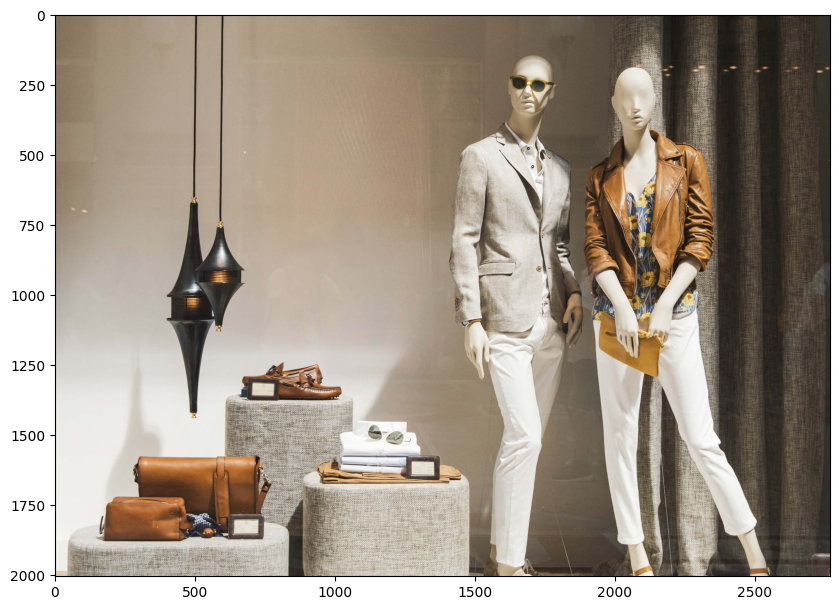

In [5]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("on")
plt.show()

## 포인트 좌표 입력 만들기

원하는 위치의 객체를 segmentation 하기 위해서는 원하는 위치를 Point로 입력해야합니다. SAM 모델에 Point를 입력하기 위해서는 두 가지 정보가 필요합니다.

- point_coords: Point 좌표 (x, y)
- points_labels: Point의 타입. Point 위치의 객체를 선택하려면 Positive Click(1)로 설정.

In [12]:
point_coords = np.array([[1720, 230]])
points_labels = np.array([1])

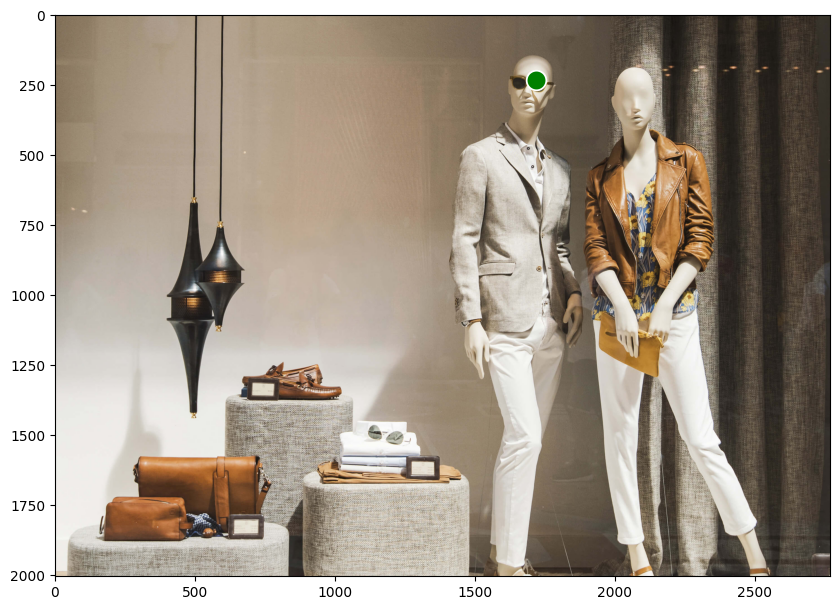

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.gca().scatter(
    point_coords[0, 0],
    point_coords[0, 1],
    color="green",
    marker="o",
    s=200,
    edgecolor="white",
    linewidth=1.25,
)
plt.axis("on")
plt.show()

## SAM 모델 추론하기

predictor의 predict 함수를 통해 추론합니다. 추론의 결과로 2 가지 정보가 출력됩니다.
- masks: 입력한 정보에 대해 3개의 mask가 출력.
- scores: 3개의 mask의 퀄리티에 대한 모델의 평가 점수. 점수가 가장 높을수록 퀄리티가 높은 mask입니다.
- low_res_logits: 저해상도 mask 출력. 이 예제에서는 사용하지 않습니다.

In [14]:
predictor.set_image(image)
masks, scores, _ = predictor.predict(point_coords, points_labels)

Mask 0


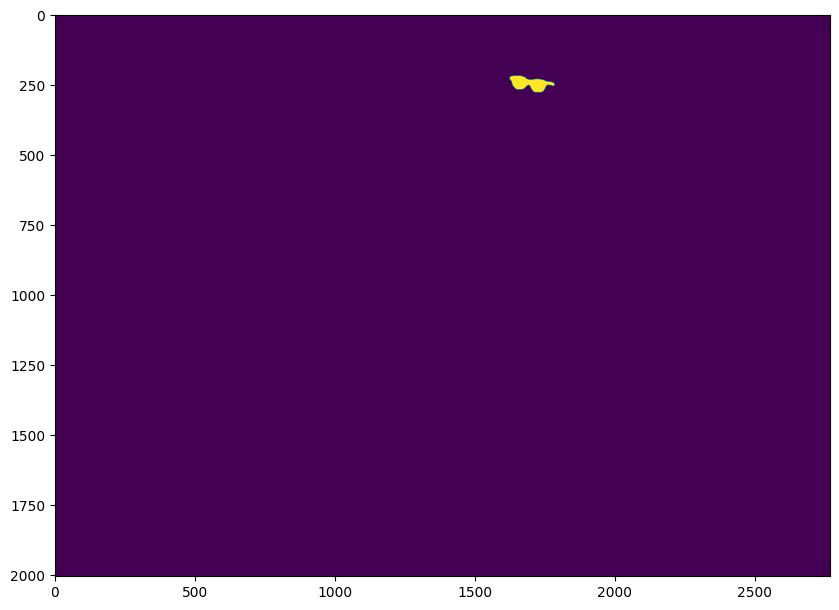

Mask 1


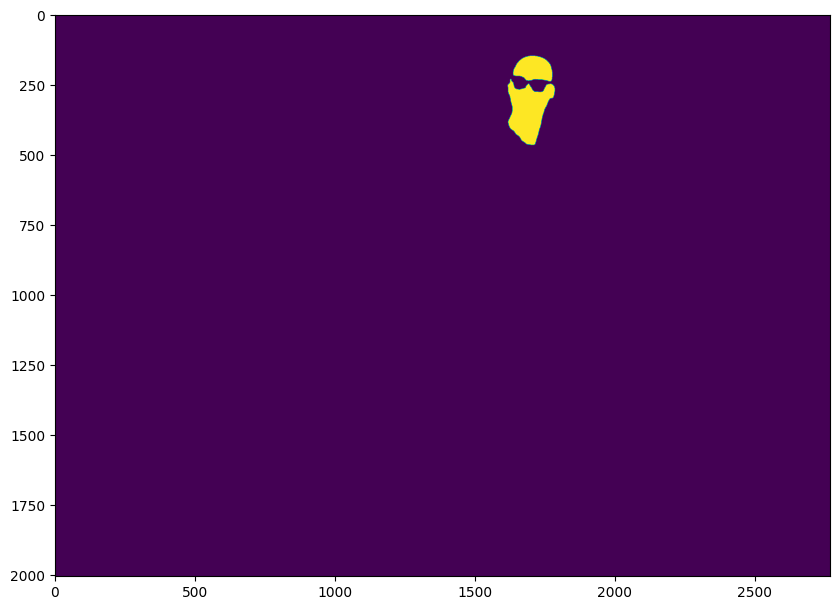

Mask 2


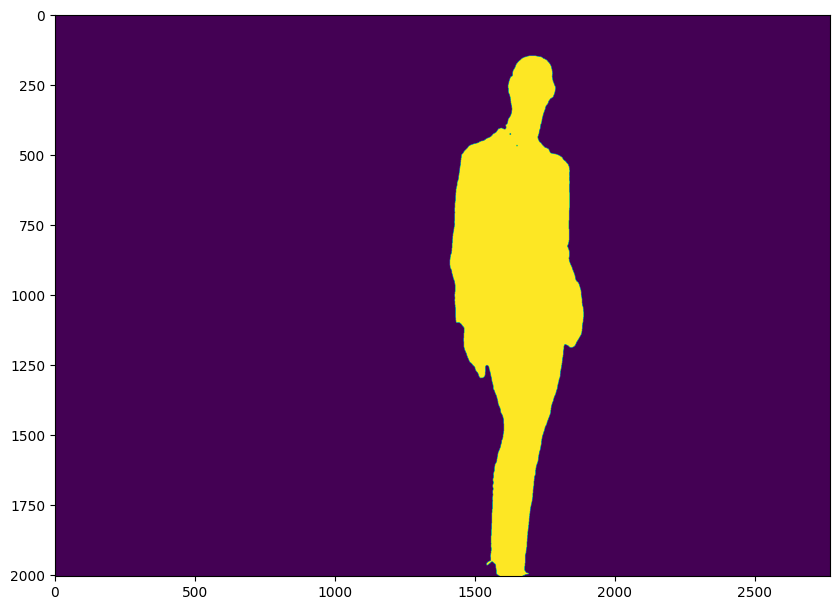

In [15]:
for i, mask in enumerate(masks):
    print(f"Mask {i}")
    plt.figure(figsize=(10, 10))
    plt.imshow(mask)
    plt.axis("on")
    plt.show()

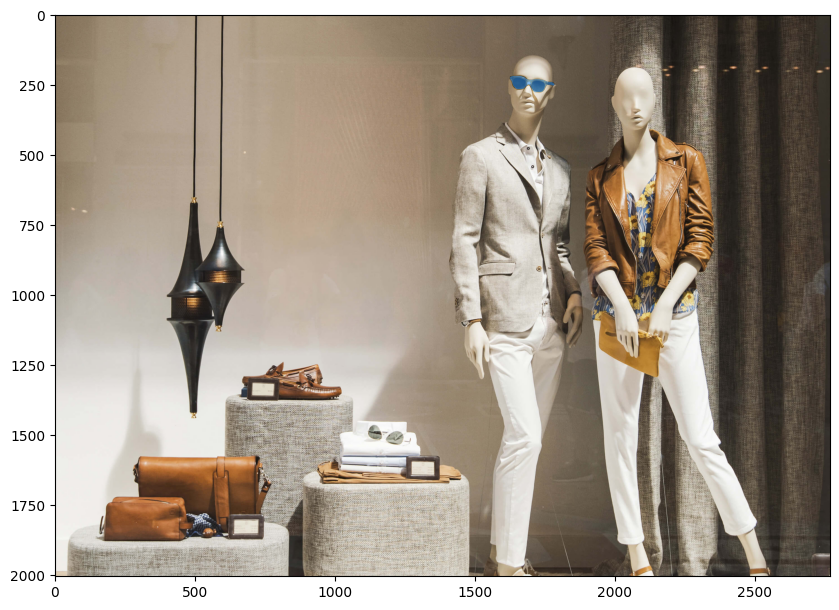

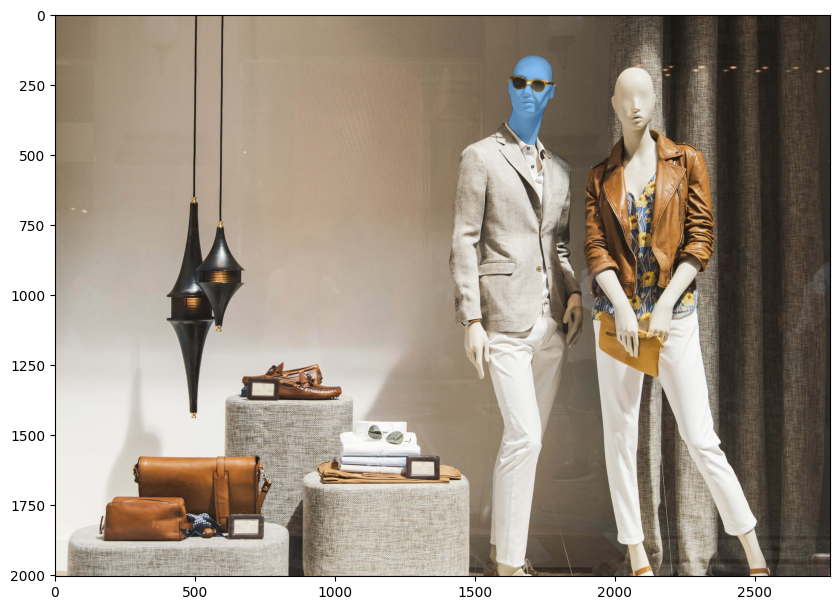

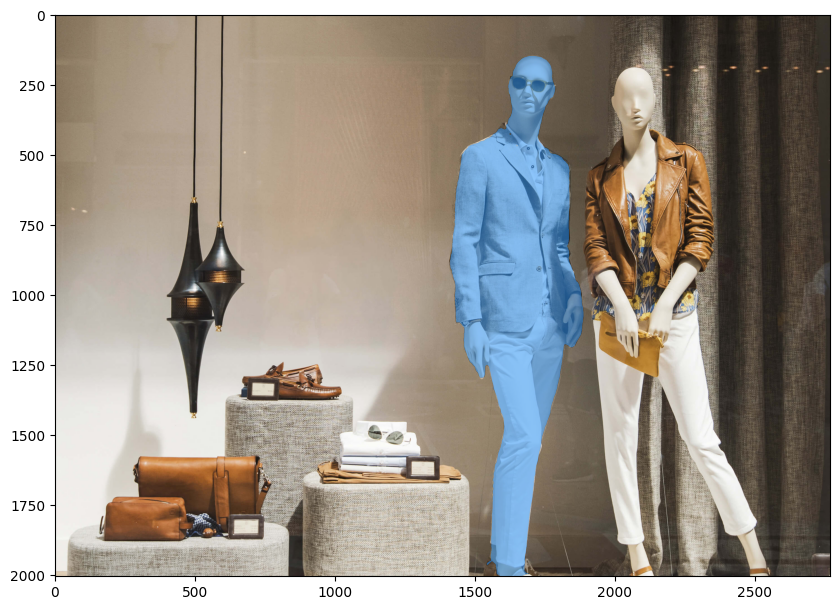

In [17]:
color = np.array([30 / 255, 144 / 255, 255 / 255, 0.5])

for mask in masks:
    mask_image = np.expand_dims(mask, axis=-1) * color.reshape(1, 1, -1)
    mask_image = (mask_image * 255).astype(np.uint8)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.imshow(mask_image)
    plt.axis("on")
    plt.show()

## 평가 점수를 이용해 세그멘테이션 마스크 선택하기

In [16]:
scores

array([0.92280793, 0.84871876, 0.959496  ], dtype=float32)

In [ ]:
mask = masks[np.argmax(scores)]

color = np.array([30/255, 144/255, 255/255, 0.5])
mask_image = np.expand_dims(mask, axis=-1) * color.reshape(1, 1, -1)
mask_image = (mask_image * 255).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(mask_image)
plt.axis("on")
plt.show()